# Exploration Data
This notebook shows data exploration to build a model (or several) in order to classify housing assistance requests thanks to the given datasets.

This is a multi-class classification task

The metric to optimize and the datasets description are explained in DS_technical_test_tutorial.ipynb Jupyter Notebook.

## import

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)


import numpy as np
import pandas as pd

from sklearn.metrics import log_loss

## Definition

## Useful functions

In [157]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


def display_missing(df):
    '''
    Function to display missing values into dataframe.
    Creates a barplots figure and outputs values.

    - input : 
        df : dataframe : data to check
    - output : 
        df_missing : dataframe : table of missing values
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing


def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=7, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
def plot_cont(X,Y,data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = data[X].value_counts()
    ty = data[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    cont

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    # plot
    fig = plt.figure(figsize = (5,11.75))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Load raw data

In [163]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


In [164]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


## Target : classes to predict

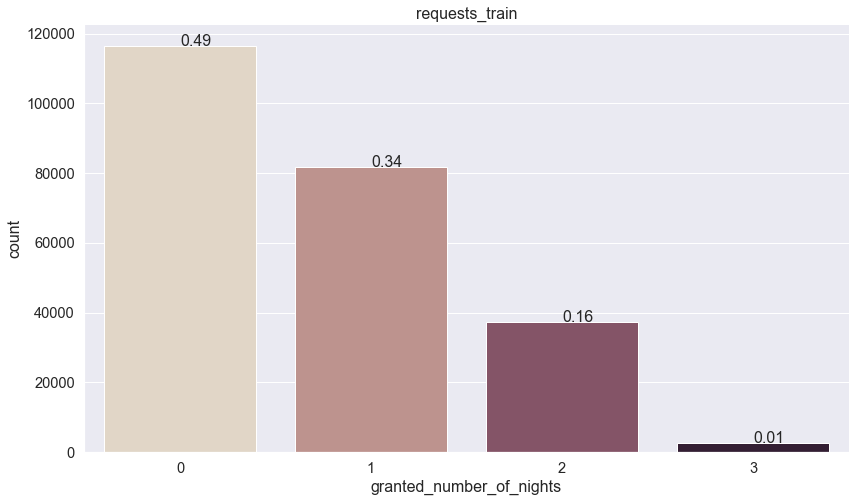

In [149]:
plot_hist_cat(x="granted_number_of_nights", data=requests_train, 
              title="requests_train")

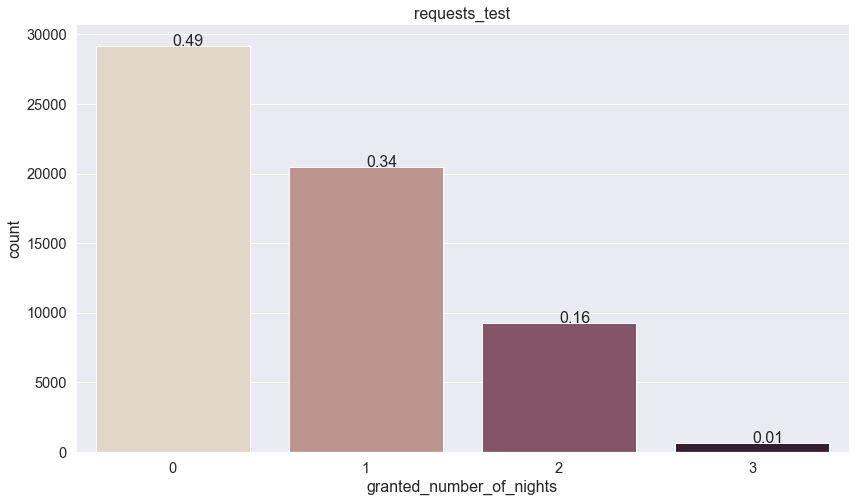

In [150]:
plot_hist_cat(x="granted_number_of_nights", data=requests_test, 
              title="requests_test")

OK => Same proportion in train and test data.

## Missing data

### requests_train

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_type,0,0.000000
victim_of_violence,0,0.000000
group_id,0,0.000000


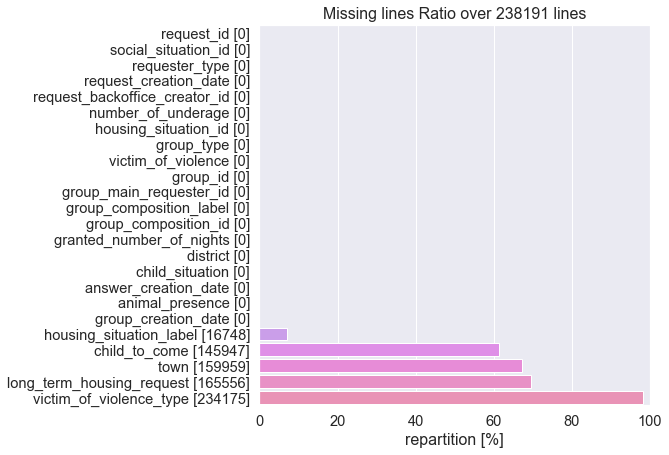

In [22]:
display_missing(requests_train)

In [56]:
requests_train["housing_situation_label"].value_counts(dropna=False)

street                                         101885
emergency structure                             68512
hotel paid by the emergency centre              17052
NaN                                             16748
other                                            9340
accomodation by a third party                    9171
shelters                                         4238
mobile or makeshift shelter                      2832
public hospital                                  2170
personal or marital home                         1722
hotel paid by the household                       810
refused to answer                                 807
hotel paid by the regional administration         660
inclusion structure                               468
parental home                                     396
psychiatric hospital                              308
stabilisation structure                           298
hotel paid by an association                      269
religious place (church, mos

### requests_test

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_id,0,0.000000
group_main_requester_id,0,0.000000
group_composition_id,0,0.000000


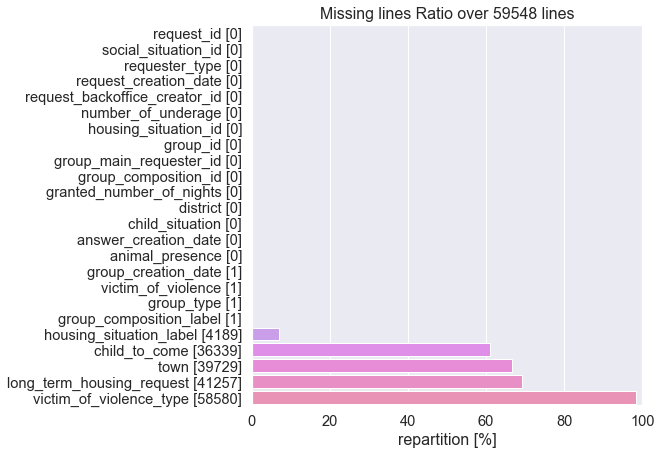

In [23]:
display_missing(requests_test)

### individuals_train

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.000260
pregnancy,14,0.003645


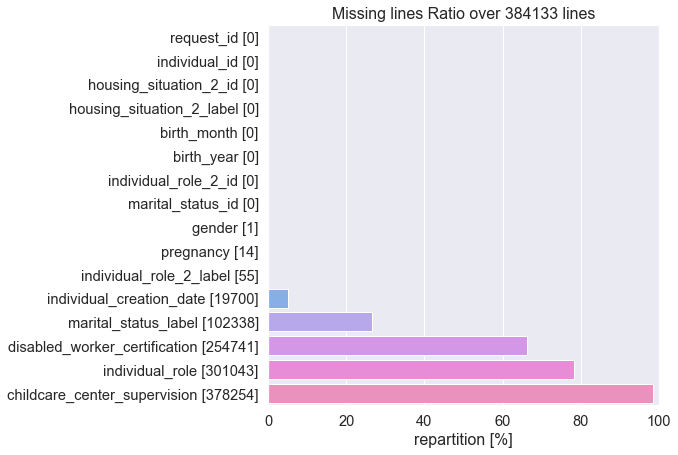

In [24]:
display_missing(individuals_train)

### individuals_test

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.001046
pregnancy,4,0.004182


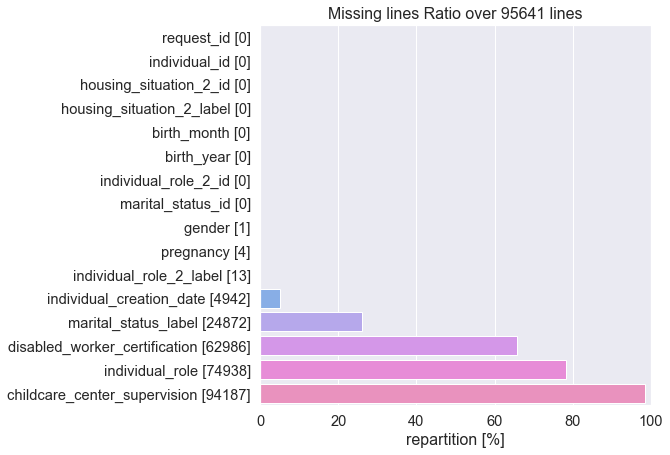

In [25]:
display_missing(individuals_test)

## Correlations

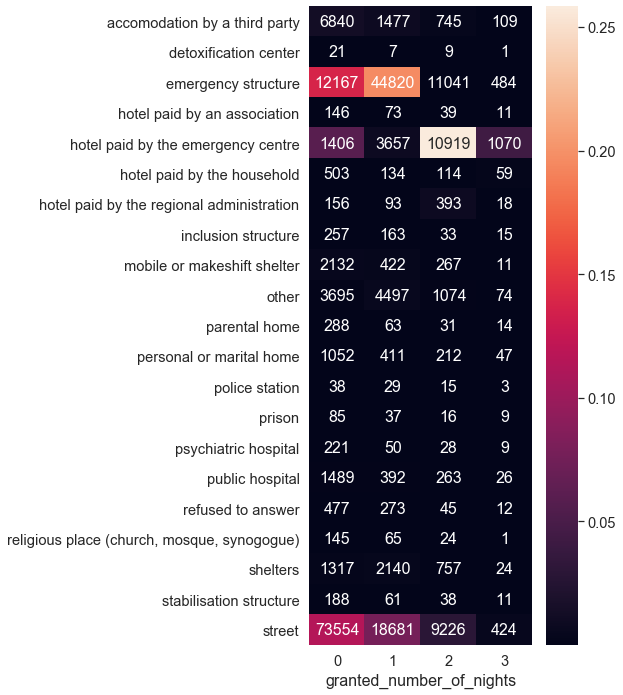

In [70]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_train)

housing_situation_label have some impact on number of nights
So we must keep it and check Nan Value???

In [73]:
requests_train["housing_situation_id"].value_counts(dropna=False)

200    101885
10      68512
50      17052
170     16748
160      9340
120      9171
100      4238
110      2832
130      2170
80       1722
40        810
180       807
190       660
30        468
70        396
140       308
20        298
220       269
210       235
150       147
60         85
90         38
Name: housing_situation_id, dtype: int64

In [74]:
requests_train["housing_situation_id"].nunique()

22

In [75]:
requests_train["housing_situation_label"].nunique() 

21

In [77]:
requests_train[requests_train["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    16748
Name: housing_situation_id, dtype: int64

In [154]:
requests_test[requests_test["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    4189
Name: housing_situation_id, dtype: int64

### Correct housing_situation_label
Only label 170 is unkonwn => add a housing_situation_label = "unknown"


In [160]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
18,e7f5a33909899231d96518842d115f23,f,2019-02-28 09:35:23.766,-1,NaN,64,0,10,man alone,2018-11-13 12:02:02.667,...,NaN,NaN,-1,2b34d48f97e14e49e1b153eb66644809,2019-02-28 09:35:23.766,user,495f0e10efffa704d9a6df257801f146,NaN,f,NaN
30,9223b74676220e533c31db6af6a94103,f,2019-02-28 18:14:35.252,-1,NaN,51,1,10,man alone,2019-02-18 20:16:56.112,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-28 18:14:35.252,user,94a8e9f8ededc41000b196c80df6d898,NaN,f,NaN
80,2d824ff45b8cdb87f2bc8e52ad97965f,f,2019-02-11 20:01:57.84,-1,NaN,51,0,10,man alone,2018-09-11 13:10:40.766,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-11 20:01:57.84,user,3e9d94a773736db14f13284fcfdcfa05,NaN,f,NaN
81,ad259fa68cc877c0d0813cbced0cefc9,f,2019-02-11 16:00:00,-1,NaN,26,1,10,man alone,2018-02-13 09:05:59.542,...,NaN,NaN,-1,9af5353cfd70982178a626350a72c4ac,2019-02-11 16:00:00,user,46375da7795ff8e5ab47ecb634ba1d7d,NaN,f,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238072,07d231ff2a7806ad6d10482d8afe3e40,f,2019-01-15 10:25:22.534,-1,f,50,0,10,man alone,2017-03-16 00:00:00.000,...,NaN,f,0,dc07b73c407e8db6e9d67a5e280dc5aa,2019-01-15 10:25:22.534,user,46847766c45846242b299e862ecf7f05,Caen,t,man
238087,0e2dbe3d86083c0b488809ed6fc505fc,f,2019-01-21 13:06:00,-1,NaN,17,0,10,man alone,2018-08-22 09:41:26.198,...,NaN,NaN,-1,4d07bdbcbf6bdae430698479ea046910,2019-01-21 13:06:00,user,5d1f069f1d71e4cca8695b36cb0d723b,NaN,f,NaN
238101,8a4075d15ad94d1a476c190ed129b421,f,2019-01-25 22:37:11.675,-1,f,63,0,20,woman alone,2018-07-01 20:40:38.068,...,NaN,NaN,-1,1af382081d6b4b9fc610c4df9c51a95b,2019-01-25 22:37:11.675,user,dbd03f487a6bc640e7d29bc0f22ee1b1,NaN,f,NaN
238116,15749cfd95735a53128c9d03f3b11be5,f,2019-01-03 15:34:06.869,-1,NaN,17,2,20,woman alone,2018-12-07 09:28:41.166,...,NaN,NaN,-1,9ef01bc20261d230caf2778b4a02ad4c,2019-01-03 15:34:06.869,user,7374a47d91d981183b62a82225687b14,NaN,f,NaN


In [165]:
requests_train.loc[requests_train["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [166]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


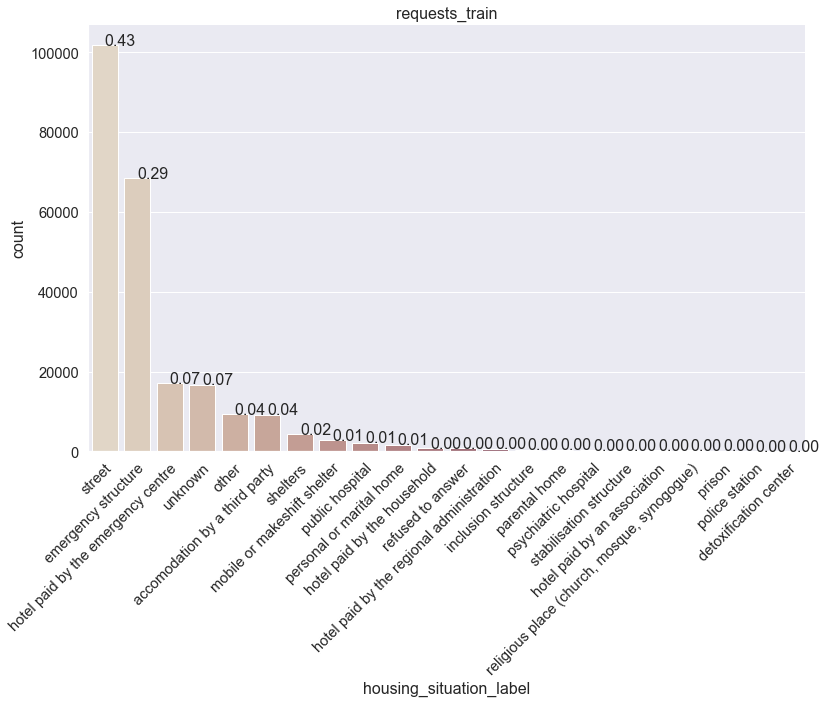

In [167]:
plot_hist_cat(x="housing_situation_label", data=requests_train, 
              title="requests_train")

In [168]:
requests_test.loc[requests_test["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [169]:
requests_test[requests_test["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


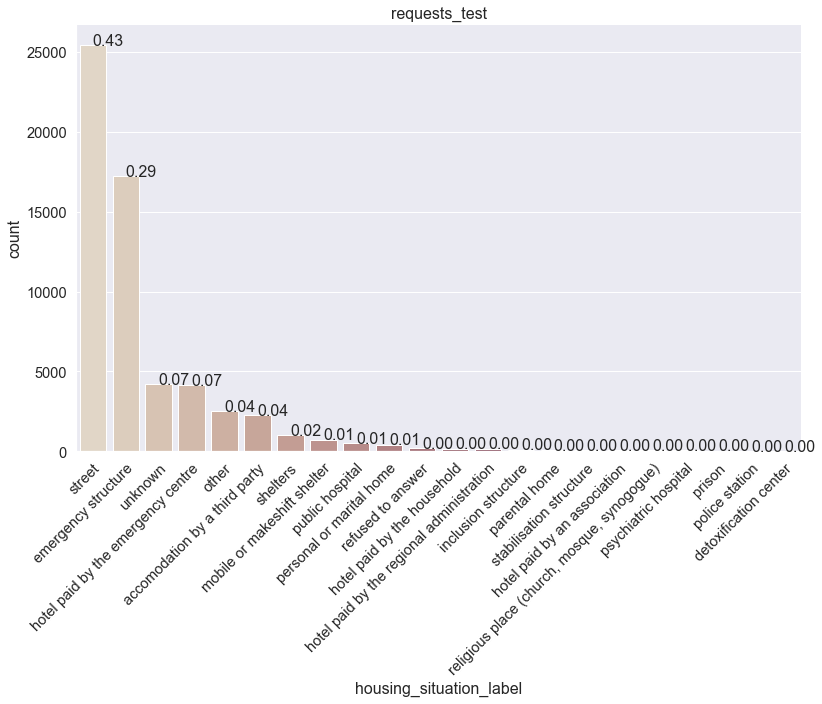

In [170]:
plot_hist_cat(x="housing_situation_label", data=requests_test, 
              title="requests_test")

In [178]:
individuals_train["housing_situation_2_id"].value_counts(dropna=False)

20    289870
35     39716
32     14872
47     14479
29      6694
44      6449
22      2599
36      2413
30      1602
34      1332
26       953
37       494
23       437
38       365
28       280
42       271
27       243
21       236
31       223
46       173
45       146
40        89
33        81
25        46
43        32
39        21
24        15
41         2
Name: housing_situation_2_id, dtype: int64

In [180]:
individuals_train["housing_situation_2_label"].value_counts(dropna=False)

on the street                                      289870
hotel paid by the emergency structure               39716
emergency accomodation                              14872
day center, social services, associations           14479
accomodated by friends or other                      6694
other                                                6449
reception center for asylum seeker                   2599
public instition (hospital, retirement home)         2413
accomodated by family                                1602
hotel not paid by an emergency structure             1332
winter plan center                                    953
private housing rental                                494
emergency accomodation centre for asylum seeker       437
public housing rental                                 365
residential roaming                                   280
child care                                            271
medical centre                                        243
emergency cent

In [182]:
individuals_train["request_id"].nunique()

238191

In [183]:
individuals_train.shape[0]

384133

In [184]:
individuals_train["individual_id"].nunique()

83513

In [185]:
individuals_train.shape[0]

384133

Several individuals for one request

And one individual can have multiple status (during time ?)

In [186]:
val_count = individuals_train["individual_id"].value_counts()
val_count[:10]

#individual_creation_date

e8ed62cc35bd5575c9956cec612777ee    92
966f79e86c663a7b5fd883584bf0a252    77
2e016b76e3d83bfd71e7c41450b4343d    73
56b563cab9ef0c330f0e49dde48e2e28    68
113da827c452404cea8be84cfebd471a    68
2eb282820e16c1f818c7fbc7a401f525    65
915eae863a5cc8fec73c5c4ec5245c49    65
eb3f64be45f0d0b673bd05bd8273c41e    65
c12874642f408a8dd82f45ad1a33886c    64
a4fe1d94a7cef97b818de51ca84cb00a    64
Name: individual_id, dtype: int64

In [188]:
individuals_train[individuals_train["individual_id"] == \
    'e8ed62cc35bd5575c9956cec612777ee']

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
6676,ccf477fb3834a1bbe91da60ebbb6b085,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
7931,192634693700446e941c58e96af93410,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
35224,b46bf1637cb74093d06ed652e4369b7a,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
35384,ee2d0e744f9a8d79578a08ccef0667c1,e8ed62cc35bd5575c9956cec612777ee,44,other,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
45498,297bf14f3a1a48567460fa7cf4ab667d,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368462,6071363e995de748ec326e39a6d838af,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
370537,206967f13f271bbd2dcbd8722a814242,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
381409,b7571cf0c35e24b46c741491799ca4b6,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f
381965,649a1a3a1210176f10ca36537deb3844,e8ed62cc35bd5575c9956cec612777ee,20,on the street,10,1971,NaN,NaN,male,NaN,NaN,30,isolated adult,10,single person,f


### child to come

In [174]:
requests_train["child_to_come"].value_counts(dropna=False)

NaN    145947
f       85878
t        6366
Name: child_to_come, dtype: int64

In [175]:
requests_train.loc[requests_train["child_to_come"].isna(),
                   "child_to_come"] = "unknown"

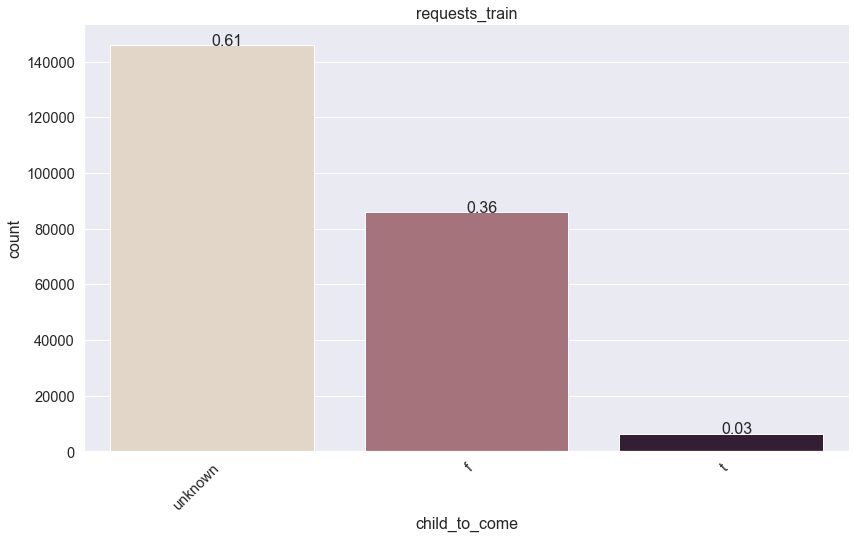

In [176]:
plot_hist_cat(x="child_to_come", data=requests_train, 
              title="requests_train")

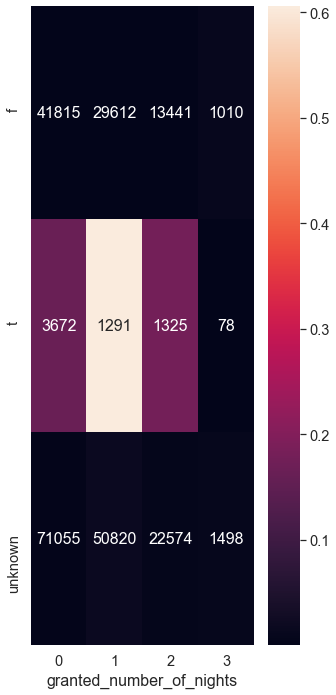

In [177]:
plot_cont(X="child_to_come", Y="granted_number_of_nights", data=requests_train)